# Rodent image classifier

This is my first image classifier project. The goal is to build a classifier of different types of rodents. Selected classes of rodents are "rabbit", "guinea pig", "hamster", "chinchilla"

#### Importing libraries

In [1]:
from fastbook import *
from fastai.vision.widgets import *
import os

### Bing search api key

In [2]:
key = os.environ.get('AZURE_SEARCH_KEY', '1656188773f64911aa8f790a7b3ba1dc')

### Updated bing search function

In [3]:
def search_images_bing(key, term, max_images: int = 100, **kwargs):    
    params = {'q':term, 'count':max_images}
    headers = {"Ocp-Apim-Subscription-Key":key}
    search_url = "https://api.bing.microsoft.com/v7.0/images/search"
    response = requests.get(search_url, headers=headers, params=params)
    response.raise_for_status()
    search_results = response.json()    
    return L(search_results['value'])

### Downloading training data

In [20]:
rodent_types = ['rabbit', 'guinea_pig', 'hamster', 'chinchilla']
rodent_queries = {'rabbit' : 'rabbit', 'guinea_pig' : 'guinea pig', 'hamster': 'hamster', 'chinchilla': 'chinchilla'}

In [25]:
data_path = Path('/notebooks/storage/data/rodents')
for rodent_type in rodent_types:
    rodent_path = data_path/rodent_type
    if not rodent_path.exists():
        rodent_path.mkdir(exist_ok=True)
        results = search_images_bing(key, rodent_queries[rodent_type])
        images = results.attrgot('contentUrl')
        download_images(rodent_path, urls=images)   

Delete all images that cannot be opened

In [77]:
images = get_image_files(data_path)
failed = verify_images(images)
failed.map(Path.unlink)
len(failed)

0

In [78]:
rodents = DataBlock((ImageBlock, CategoryBlock), 
                    get_items=get_image_files, 
                    splitter=RandomSplitter(valid_pct=0.2, seed=42),
                    get_y=parent_label,
                    item_tfms=Resize(128))

In [113]:
dataloaders = rodents.dataloaders(data_path)

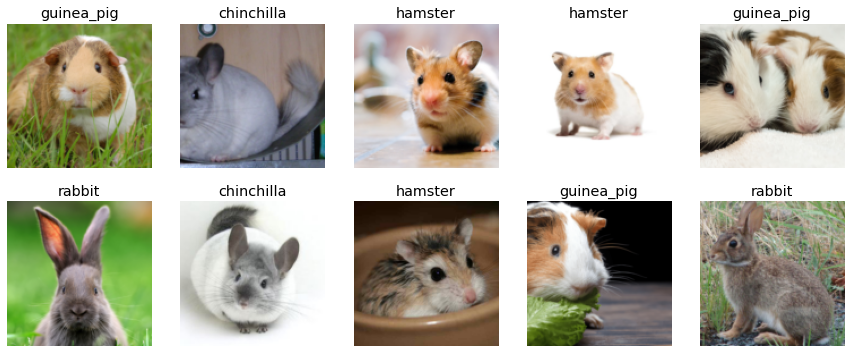

In [80]:
dataloaders.train.show_batch(max_n=10, nrows=2)

In [116]:
learner = cnn_learner(dataloaders,resnet34, metrics=error_rate)

In [117]:
learner.fine_tune(6)

epoch,train_loss,valid_loss,error_rate,time
0,2.400480,0.757520,0.240000,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.927087,0.551252,0.226667,00:06
1,0.717871,0.328058,0.120000,00:06
2,0.532157,0.182262,0.093333,00:05
3,0.415840,0.128577,0.053333,00:05
4,0.344302,0.115106,0.053333,00:06
5,0.285541,0.119806,0.053333,00:05


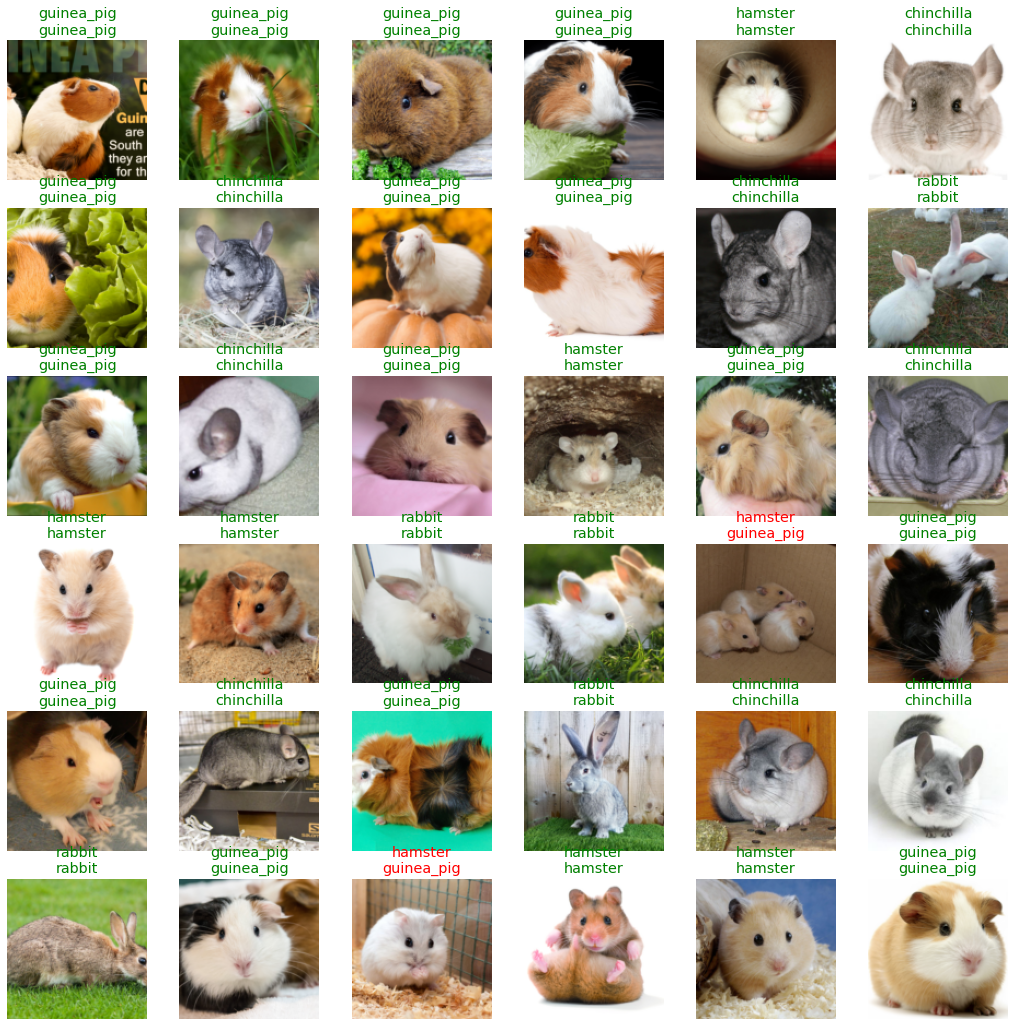

In [118]:
learner.show_results(max_n=36)

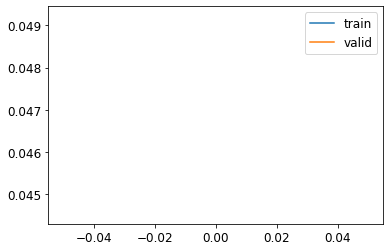

In [119]:
learner.recorder.plot_loss(0,True)

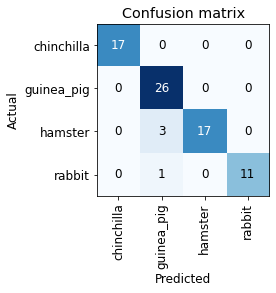

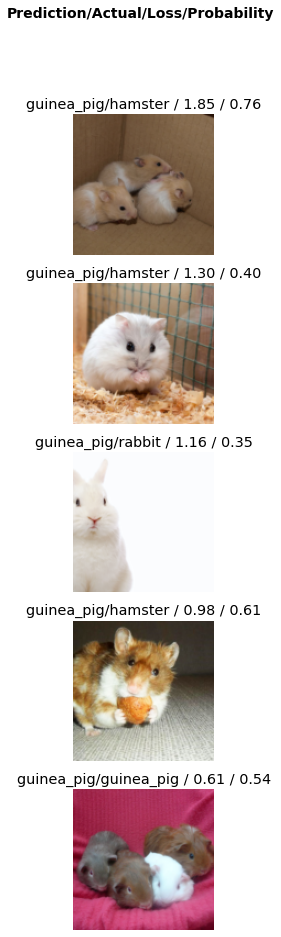

In [122]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()
interp.plot_top_losses(5, nrows=5)

In [98]:
cleaner = ImageClassifierCleaner(learner)
cleaner

In [111]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), data_path/cat/"m")

In [121]:
learner.export('/notebooks/storage/models/rodents/r34_ep6_err0_053.pkl')